In [65]:
import cv2
import os
import numpy as np
import random
#import cPickle as pickle
import pickle
import warnings
import torch
import torchvision
import sys
import copy
%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow


In [66]:
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Evolution.AI---RN')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

img_size = 75
size = 5 #radius of object
question_size = 19 ## (6 for one-hot vector of color), 2 for question type, 5 for question subtype
q_type_idx = 12
sub_q_type_idx = 14
"""Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""

nb_questions = 15
dirs = './data'
dirs = F"/content/drive/My Drive/Evolution.AI---RN/data"
colors = [
    (0,0,255),##r
    (0,255,0),##g
    (255,0,0),##b
    (0,156,255),##o
    (128,128,128),##k
    (0,255,255)##y
]

def center_generate(objects):
    while True:
        pas = True
        center = np.random.randint(0+size, img_size - size, 2)
        #a =  np.random.randint(0+size, img_size - size, 2)
        #center = np.asarray([a[1],a[0]])#flip x-y coordinate
        if len(objects) > 0:
            for name,c,shape in objects:
                if ((center - c) ** 2).sum() < ((size * 2) ** 2):
                    pas = False
        if pas:
            return center
            
def build_dataset(idx):#for each image
    objects = []
    boxes = []
    labels = []
    img = np.ones((img_size,img_size,3)) * 255
    for color_id,color in enumerate(colors):  
        center = center_generate(objects)
        x_min = center[0] - size
        x_max = center[0] + size
        y_min = center[1] - size
        y_max = center[1] + size
        boxes.append([x_min, y_min, x_max, y_max])
        
        if random.random()<0.5:
            start = (center[0]-size, center[1]-size)
            end = (center[0]+size, center[1]+size)
            cv2.rectangle(img, start, end, color, -1)#artificially generates recs
            objects.append((color_id,center,'r'))
            labels.append(color_id+1)#label starts from 1
        else:
            center_ = (center[0], center[1])
            cv2.circle(img, center_, size, color, -1)#artificially generates circles
            objects.append((color_id,center,'c'))
            labels.append(color_id+7)

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = torch.ones((6,), dtype=torch.int64)*100
    iscrowd = torch.zeros((6,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    #ternary_questions = []
    binary_questions = []
    norel_questions = []
    #ternary_answers = []
    binary_answers = []
    norel_answers = []
    """Non-relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx] = 1
        subtype = random.randint(0,2)
        question[subtype+sub_q_type_idx] = 1
        norel_questions.append(question)
        """Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""
        if subtype == 0:#14
            """query shape->rectangle/circle"""
            if objects[color][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 1:#15
            """query vertical position->yes/no"""
            if objects[color][1][0] < img_size / 2:#check row ind
                answer = 0
            else:
                answer = 1

        elif subtype == 2:#16
            """query horizontal position->yes/no"""
            if objects[color][1][1] < img_size / 2:#check col ind
                answer = 0
            else:
                answer = 1
        norel_answers.append(answer)
    
    """Binary Relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx+1] = 1
        subtype = random.randint(0,4)
        question[subtype+sub_q_type_idx] = 1
        
        if subtype == 0:#14
            """closest-to->rectangle/circle"""
            my_obj = objects[color][1]# coordinate of object's centre
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            dist_list[dist_list.index(0)] = 999
            closest = dist_list.index(min(dist_list))
            if objects[closest][2] == 'r':
                answer = 2
            else:
                answer = 3
                
        elif subtype == 1:#15
            """furthest-from->rectangle/circle"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            furthest = dist_list.index(max(dist_list))
            if objects[furthest][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 2:#16
            """count->1~6"""
            my_obj = objects[color][2]
            count = -1
            for obj in objects:
                if obj[2] == my_obj:
                    count +=1 
            answer = count+4
        elif subtype == 3:#17
            ''' if current object is above object 2--->yes or no'''
            
            color2 = random.randint(0,5)#select second color
            question[color2+6] = 1
            obj_1 = objects[color][1]#reference object
            obj_2 = objects[color2][1]
            if obj_1[0]>obj_2[0]:#compare row ind
                answer = 0
            else:
                answer = 1
      
        elif subtype == 4:#18
            ''' if color2 is on the left to the current object --->yes or no'''
            color2 = random.randint(0,5)#select second color
            question[color2+6] = 1
            obj_1 = objects[color][1]#reference object
            obj_2 = objects[color2][1]
            if obj_1[1]<obj_2[1]:#compare col ind
                answer = 0
            else:
                answer = 1

        binary_questions.append(question)
        binary_answers.append(answer)
    binary_relations = (binary_questions, binary_answers)
    norelations = (norel_questions, norel_answers)
    
    img = img/255.
    dataset = (img, binary_relations, norelations, target)
    return dataset


In [4]:
train_size = 500
test_size = 100
val_size = 100
random.seed(2020)
np.random.seed(2020)
print('building train datasets...')
train_datasets = [build_dataset(idx) for idx in range(train_size)]
print('building test datasets...')
test_datasets = [build_dataset(idx) for idx in range(train_size,train_size+test_size)]
print('building validation datasets...')
val_datasets = [build_dataset(idx) for idx in range(train_size+test_size,train_size+test_size+val_size)]
print('done!')

building train datasets...
building test datasets...
building validation datasets...
done!


In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
print('model loaded')

model loaded


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47 12 57 22
58 18 67 28
28 59 38 69
9 46 19 56
47 13 52 22
28 58 38 69
47 13 49 21


Text(0.5, 1.0, 'Pretrained Faster RCNN')

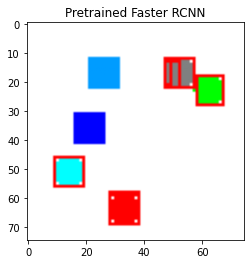

In [6]:
data = build_dataset(1) 
img = data[0]
#img = cv2.imread("/content/drive/My Drive/Evolution.AI---RN/people.jpg")
#img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure()
# plt.imshow(img)
# plt.show()
im = torch.from_numpy(img).float().permute(2,0,1)
predictions = model([im])
bounding_boxes=predictions[0]['boxes']
for i in range(len(bounding_boxes)):
    x1, x2, x3, x4 = map(int, bounding_boxes[i].tolist())
    print(x1, x2, x3, x4)
    image = cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0,0),1)

plt.imshow(image)
plt.title('Pretrained Faster RCNN')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Initialised Faster RCNN')

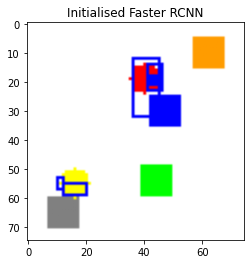

In [7]:
num_classes = 12+1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
data = build_dataset(1) 
img = data[0]
#img = cv2.imread("/content/drive/My Drive/Evolution.AI---RN/people.jpg")
#img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure()
# plt.imshow(img)
# plt.show()
im = torch.from_numpy(img).float().permute(2,0,1)
predictions = model([im])
bounding_boxes=predictions[0]['boxes']
for i in range(len(bounding_boxes)):
  if i <6:
      x1, x2, x3, x4 = map(int, bounding_boxes[i].tolist())
      #print(x1, x2, x3, x4)
      image = cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0,0),1)

plt.imshow(image[:,:,::-1])
plt.title('Initialised Faster RCNN')

In [12]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
#cp references/detection/engine.py ../
#cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9733 (delta 0), reused 1 (delta 0), pack-reused 9731
Receiving objects: 100% (9733/9733), 11.47 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (6769/6769), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [13]:
from engine import train_one_epoch, evaluate
import utils
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 13

# imgs = [data[0].transpose(2,0,1) for data in train_datasets]
# imgs = torch.as_tensor(imgs, dtype=torch.float32)
# targets = [data[3] for data in train_datasets]
# dataset = [imgs,targets]
# imgs = [data[0].transpose(2,0,1) for data in test_datasets]
# imgs = torch.as_tensor(imgs, dtype=torch.float32)
# targets = [data[3] for data in test_datasets]
# dataset_test = [imgs,targets]

# define training and validation data loaders
print('preparing RCNN dataset')
dataset  = [[torch.as_tensor(data[0].transpose(2,0,1), dtype=torch.float32),data[3]] for data in train_datasets]
dataset_test = [[torch.as_tensor(data[0].transpose(2,0,1), dtype=torch.float32),data[3]] for data in test_datasets]

# indices = torch.randperm(train_size).tolist()
# dataset = torch.utils.data.Subset(dataset, indices)
# indices = torch.randperm(test_size).tolist()
# dataset_test = torch.utils.data.Subset(dataset_test, indices)


data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)



preparing RCNN dataset


In [10]:
# # get the model using our helper function
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.1)
# let's train it for 10 epochs
num_epochs = 15
print('start training')
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

start training
Epoch: [0]  [  0/100]  eta: 0:02:07  lr: 0.000555  loss: 3.8881 (3.8881)  loss_classifier: 3.0012 (3.0012)  loss_box_reg: 0.8283 (0.8283)  loss_objectness: 0.0494 (0.0494)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 1.2724  data: 0.1673  max mem: 3684
Epoch: [0]  [ 20/100]  eta: 0:01:14  lr: 0.010645  loss: 1.7152 (2.0619)  loss_classifier: 0.7526 (1.1597)  loss_box_reg: 0.9378 (0.8908)  loss_objectness: 0.0035 (0.0084)  loss_rpn_box_reg: 0.0022 (0.0030)  time: 0.9120  data: 0.0130  max mem: 3951
Epoch: [0]  [ 40/100]  eta: 0:00:55  lr: 0.020736  loss: 0.8954 (1.4923)  loss_classifier: 0.5501 (0.8553)  loss_box_reg: 0.3411 (0.6290)  loss_objectness: 0.0002 (0.0048)  loss_rpn_box_reg: 0.0021 (0.0033)  time: 0.9158  data: 0.0141  max mem: 3951
Epoch: [0]  [ 60/100]  eta: 0:00:36  lr: 0.030827  loss: 0.4639 (1.1547)  loss_classifier: 0.1826 (0.6359)  loss_box_reg: 0.2721 (0.5128)  loss_objectness: 0.0007 (0.0035)  loss_rpn_box_reg: 0.0009 (0.0025)  time: 0.9203  data: 0.0125 

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


6 38 17 48
23 52 33 63
40 37 50 48
19 4 29 14
6 11 16 22
60 16 70 25


23 53 33 63
7 39 17 49
19 4 29 14
40 38 50 48
61 16 71 26
6 12 16 22


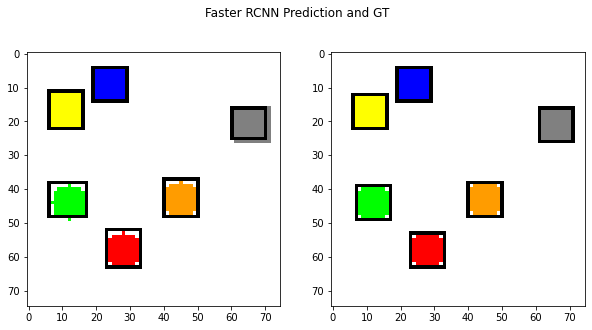

In [10]:
data = test_datasets[9]
img1 = copy.deepcopy(data[0])
img2 = copy.deepcopy(data[0])
im = torch.from_numpy(img1.transpose(2,0,1)).float().to(device)
model.eval()
predictions = model([im])
bounding_boxes=predictions[0]['boxes']
for i in range(len(bounding_boxes)):
  if i < 6:
    x1, y1, x2, y2 = map(int, bounding_boxes[i].tolist())
    print(x1, y1, x2, y2)
    image1 = cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 0,0),1)
print('\n')
bounding_boxes=data[3]['boxes']
for i in range(len(bounding_boxes)):
  if i < 6 :
    x1, y1, x2, y2 = map(int, bounding_boxes[i].tolist())
    print(x1, y1, x2, y2)
    image2 = cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 0,0),1)
fig, axs = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Faster RCNN Prediction and GT')
axs[0].imshow(image1[:,:,::-1])
axs[1].imshow(image2[:,:,::-1])

In [12]:
predictions

[{'boxes': tensor([[10.9276, 18.0163, 20.9878, 28.0142],
          [39.0251, 15.0070, 49.0194, 24.9764],
          [37.9921, 60.0188, 47.9841, 69.9687],
          [26.9959, 23.0188, 37.0271, 33.0188],
          [26.9719, 57.9919, 37.0080, 68.0279],
          [15.0040,  2.0051, 24.9637, 11.9731]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([11,  4,  8,  6,  1,  3], device='cuda:0'),
  'scores': tensor([0.9995, 0.9994, 0.9994, 0.9992, 0.9990, 0.9989], device='cuda:0',
         grad_fn=<IndexBackward>)}]

In [13]:
#save model
model_save_name = 'rcnn.pth'
path = F"/content/drive/My Drive/Evolution.AI---RN/model_saved/{model_save_name}"  
torch.save(model.state_dict(), path)

In [9]:
## load model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_save_name = 'rcnn.pth'
path = F"/content/drive/My Drive/Evolution.AI---RN/model_saved/{model_save_name}" 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 12+1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(path))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

55 37 66 47
23 49 33 59
28 1 38 10
12 27 23 38
6 49 17 60
45 44 55 54


Text(0.5, 1.0, 'Initialised Faster RCNN')

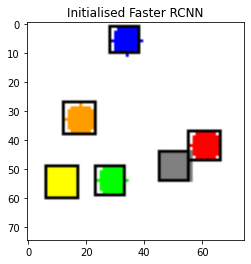

In [15]:
img,target = next(iter(data_loader_test))
im = img[0].to(device)

predictions = model([im])
im = im.permute(1,2,0).cpu().numpy()
bounding_boxes=predictions[0]['boxes']
#bounding_boxes=target[0]['boxes']
for i in range(len(bounding_boxes)):
  if i < 6:
    x1, y1, x2, y2 = map(int, bounding_boxes[i].tolist())
    print(x1, y1, x2, y2)
    image = cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0,0),1)

plt.imshow(image[:,:,::-1])
plt.title('Initialised Faster RCNN')

In [22]:
img,target = next(iter(data_loader))
predictions = model(torch.stack(img).to(device))
predictions

[{'boxes': tensor([[18.9589,  0.9424, 29.0212, 10.9980],
          [62.1077, 26.9824, 71.9904, 37.0079],
          [63.0159, 63.9271, 73.0277, 73.9690],
          [50.9631,  1.0333, 60.9878, 11.0290],
          [62.9762, 54.0219, 73.0428, 63.8431],
          [25.9891, 48.9654, 36.0258, 59.0155],
          [62.6649, 61.9782, 72.9428, 73.7896],
          [62.6092, 62.9581, 73.4788, 73.8936]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([ 9,  5,  6,  4,  8,  1,  2, 12], device='cuda:0'),
  'scores': tensor([0.9995, 0.9995, 0.9994, 0.9994, 0.9993, 0.9993, 0.1545, 0.0554],
         device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[64.0189,  5.0021, 74.0257, 15.0409],
          [ 1.0135, 26.0013, 11.0106, 36.0321],
          [43.0092, 42.9998, 53.0063, 53.0008],
          [27.9918,  8.0031, 37.9968, 18.0582],
          [55.9639, 12.0649, 66.0006, 22.0766],
          [30.9930, 38.0228, 41.0026, 48.0049]], device='cuda:0',
         grad_fn=<StackBackwar

In [67]:
boxes =torch.stack([t['boxes'][:6] for t in predictions])
centers = (boxes[:,:,:2]+boxes[:,:,2:])/2
#centers
labels = torch.stack([t['labels'][:6] for t in predictions])
one_hot = torch.nn.functional.one_hot(labels)

result = torch.cat((centers,one_hot),dim=2)

In [69]:
boxes.size

<function Tensor.size>

In [59]:
one_hot.size()

torch.Size([5, 6, 13])

In [64]:
img,target = next(iter(data_loader_test))
im = img[0].to(device)
im.size()

torch.Size([3, 75, 75])